# Imports

In [1477]:
import re
import requests
import pandas as pd
from nltk import FreqDist
from nltk import ngrams
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

# Activity 3

## 3.1 Sub-activity: Loading and pre-processing of text data

In [1478]:
# Global variables
WIKIDATA_API_ENDPOINT = "https://www.wikidata.org/w/api.php"

WIKIDATA_COMMON_PARAMS = {
    "ids":"",
    "props": "",
    "format":"json",
    "languages": "en",
    "formatversion": "2",
    "sitefilter": "enwiki",
    "action": "wbgetentities"
}

### Task 1

In [1479]:
def get_turing_award_recipients():

    wikidata_entity_params = {
        "srlimit":100,
        "format":"json",
        "list":"search",
        "action":"query",
        "formatversion": "2",
        "srprop":"sectiontitle",
        "srsearch": "haswbstatement:P166=Q185667",
    }
    
    wikidata_ID_response = requests.get(WIKIDATA_API_ENDPOINT, params = wikidata_entity_params)
    wikidata_ID_data = wikidata_ID_response.json()    
    wikidata_IDs = [entity_ID["title"] for entity_ID in wikidata_ID_data["query"]["search"]]

    return wikidata_IDs

In [1480]:
wikidata_IDs = get_turing_award_recipients()

### Task 2

In [1481]:
def get_wikipedia_content(wikidata_ID):
    wikipedia_API_endpoint = "https://en.wikipedia.org/w/api.php"
    
    WIKIDATA_COMMON_PARAMS["ids"] = wikidata_ID
    WIKIDATA_COMMON_PARAMS["props"] = "sitelinks"
    
    wikidata_response = requests.get(WIKIDATA_API_ENDPOINT, params = WIKIDATA_COMMON_PARAMS)
    wikidata_response_data = wikidata_response.json()

    # To extract content from the wikipidia page, we have to use titles gained the wikidata IDs, since the titles of wikipedia pages are unique.
    wikidata_title = wikidata_response_data["entities"][wikidata_ID]["sitelinks"]["enwiki"]["title"]    

    wikipedia_params = {
        "titles": "",
        "format": "json",
        "action": "query",
        "prop": "extracts",
        "formatversion": "2",
        "titles": wikidata_title,
        "exsectionformat": "wiki"
    }
    
    wikipedia_content_response = requests.get(wikipedia_API_endpoint, params = wikipedia_params)
    wikipedia_content_data = wikipedia_content_response.json()
    wikipedia_content = wikipedia_content_data["query"]["pages"][0]["extract"]
    return wikipedia_content


### Task 3

In [1482]:
def get_award_winners_info(wikidata_ID):
    
    WIKIDATA_COMMON_PARAMS["ids"] = wikidata_ID
    WIKIDATA_COMMON_PARAMS["props"] = "claims|sitelinks"

    wikidata_title_response = requests.get(WIKIDATA_API_ENDPOINT, params = WIKIDATA_COMMON_PARAMS)
    wikidata_title_data = wikidata_title_response.json()

    # Extract name
    try:
        # Some names have brackets, so we split that part and take the name
        wikidata_name = wikidata_title_data["entities"][wikidata_ID]["sitelinks"]["enwiki"]["title"].split(" (")[0]
    except KeyError:
        wikidata_name = None

    # Extract intro from wikipedia page
    try:
        wikipedia_content = get_wikipedia_content(wikidata_ID)
    except KeyError:
        wikipedia_intro = None
    else:
        content_remove_newline_to_space = wikipedia_content.replace("\n", " ")
        content_with_p_tag = re.sub(r"<\/?(?!p)\w*\b[^>]*>", "", content_remove_newline_to_space.split("<h2>")[0])
        paragraphs = re.findall(r'<p>(.+?)</p>', content_with_p_tag)
        wikipedia_intro = "\n".join(paragraphs)

    # Extract gender ID to get gender from "sex or gender (P21)"
    try:
        wikidata_gender_id = wikidata_title_data["entities"][wikidata_ID]["claims"]["P21"][0]["mainsnak"]["datavalue"]["value"]["id"]
    except KeyError:
        wikidata_gender_id = None
        
    # Get birth date from "date of birth (P569)"
    try:
        wikidata_birth_date = wikidata_title_data["entities"][wikidata_ID]["claims"]["P569"][0]["mainsnak"]["datavalue"]["value"]["time"].split("T")[0].split("+")[1]
    except KeyError:
        wikidata_birth_date = None

    # Extract birth place ID to get birth place from "place of birth (P19)"
    try:
        wikidata_birth_place = wikidata_title_data["entities"][wikidata_ID]["claims"]["P19"][0]["mainsnak"]["datavalue"]["value"]["id"]
    except KeyError:
        wikidata_birth_place = None

    # Extract employer ID to get employer from "employer (P108)"
    # employer ID is inside of "mainsnak" key
    try:
        wikidata_employer_mainsnaks = wikidata_title_data["entities"][wikidata_ID]["claims"]["P108"]
    except KeyError:
        wikidata_employers_IDs = None
    else:
        wikidata_employers_IDs = [wikidata_employer_ID["mainsnak"]["datavalue"]["value"]["id"] for wikidata_employer_ID in wikidata_employer_mainsnaks]
        
    # Extract educated at ID to get educated at from "educated at (P69)"
    # educated at ID is inside of "mainsnak" key
    try:
        wikidata_educated_at_mainsnaks = wikidata_title_data["entities"][wikidata_ID]["claims"]["P69"]
    except KeyError:
        wikidata_educated_at_IDs = None
    else:
        wikidata_educated_at_IDs = [wikidata_educated_at_ID["mainsnak"]["datavalue"]["value"]["id"] for wikidata_educated_at_ID in wikidata_educated_at_mainsnaks]

    # Join the IDs per person that we want to get info from into a list
    entity_info_request_IDs = [wikidata_gender_id, wikidata_birth_place, "|".join(wikidata_employers_IDs), "|".join(wikidata_educated_at_IDs)]
    
    # A list that contains all the info of the person
    
    entity_info = [wikidata_name, wikipedia_intro, wikidata_birth_date]

    WIKIDATA_COMMON_PARAMS["props"] = "labels"
    for i in range(len(entity_info_request_IDs)):
        entity_values = []
        
        WIKIDATA_COMMON_PARAMS["ids"] = entity_info_request_IDs[i]
        
        response = requests.get(WIKIDATA_API_ENDPOINT, params = WIKIDATA_COMMON_PARAMS)
        data = response.json()

        if i == 0 or i == 1:
            try:
                entity_value = data["entities"][entity_info_request_IDs[i]]["labels"]["en"]["value"]
            except KeyError:
                entity_info.append(None)
            else:
                entity_info.append(entity_value)

        else:
            try:
                entity_IDs = entity_info_request_IDs[i].split("|")
            except AttributeError:
                entity_IDs = []

            for entity_ID in entity_IDs:
                try:
                    entity_value = data["entities"][entity_ID]["labels"]["en"]["value"]
                except KeyError:
                    entity_values.append(None)
                else:
                    entity_values.append(entity_value)
            
            entity_info.append(entity_values)
    
    return entity_info[0], entity_info[1], entity_info[2], entity_info[3], entity_info[4], entity_info[5], entity_info[6]

In [1483]:
award_winners = {
    "name": [],
    "intro": [],
    "birth_date": [],
    "gender": [],
    "birth_place": [],
    "employer": [],
    "educated_at": []
}

for wikidata_ID in wikidata_IDs:
    wikidata_name, wikipedia_intro, wikidata_birth_date, wikidata_gender, wikidata_birth_place, wikidata_employer, wikidata_educated_at = get_award_winners_info(wikidata_ID)
    award_winners["name"].append(wikidata_name)
    award_winners["intro"].append(wikipedia_intro)
    award_winners["birth_date"].append(wikidata_birth_date)
    award_winners["gender"].append(wikidata_gender)
    award_winners["birth_place"].append(wikidata_birth_place)
    award_winners["employer"].append(wikidata_employer)
    award_winners["educated_at"].append(wikidata_educated_at)

### Task 4

In [1484]:
print("The names of all award winners are (alphabetical order): \n\n{}.".format(", ".join(sorted(award_winners["name"]))))

The names of all award winners are (alphabetical order): 

Adi Shamir, Alan Kay, Alan Perlis, Alfred Aho, Allen Newell, Amir Pnueli, Andrew Yao, Barbara Liskov, Bob Kahn, Butler Lampson, Charles Bachman, Charles P. Thacker, Dana Scott, David Patterson, Dennis Ritchie, Donald Knuth, Douglas Engelbart, E. Allen Emerson, Edgar F. Codd, Edmund M. Clarke, Edsger W. Dijkstra, Edward Feigenbaum, Edwin Catmull, Fernando J. Corbató, Frances Allen, Fred Brooks, Geoffrey Hinton, Herbert A. Simon, Ivan Sutherland, Jack Dongarra, James H. Wilkinson, Jeffrey Ullman, Jim Gray, John Backus, John Cocke, John Hopcroft, John L. Hennessy, John McCarthy, Joseph Sifakis, Judea Pearl, Juris Hartmanis, Ken Thompson, Kenneth E. Iverson, Kristen Nygaard, Leonard Adleman, Leslie Lamport, Leslie Valiant, Manuel Blum, Martin Hellman, Marvin Minsky, Maurice Wilkes, Michael O. Rabin, Michael Stonebraker, Niklaus Wirth, Ole-Johan Dahl, Pat Hanrahan, Peter Naur, Raj Reddy, Richard E. Stearns, Richard Hamming, Richard 

### Task 5

#### (a)

In [1485]:
award_winners_intro = pd.DataFrame(columns = ["winner_name", "count_words", "count_sentences", "count_paragraphs", "common_words"])

#### (b)

In [1486]:
award_winners_intro["winner_name"] = award_winners["name"]
award_winners_intro["count_words"] = pd.DataFrame(award_winners["intro"]).apply(lambda x: x[0].split(), axis = 1).apply(lambda x: len(x))
award_winners_intro["count_sentences"] = pd.DataFrame(award_winners["intro"]).apply(lambda x: sent_tokenize(x[0]), axis = 1).apply(lambda x: len(x))
award_winners_intro["count_paragraphs"] = pd.DataFrame(award_winners["intro"]).apply(lambda x: x[0].split("\n"), axis = 1).apply(lambda x: len(x))
award_winners_intro["common_words"] = pd.DataFrame(award_winners["intro"]).apply(lambda x: FreqDist(x[0].split()).most_common(10), axis = 1).apply(lambda x: [i[0] for i in x]).apply(lambda x: ", ".join(x))
award_winners_intro

,winner_name,count_words,count_sentences,count_paragraphs,common_words
0,Tim Berners-Lee,359,17,4,"the, of, and, He, a, is, Web, as, World, Wide"
1,Yoshua Bengio,91,4,2,"and, the, of, for, Bengio, is, a, work, deep, ..."
2,Geoffrey Hinton,181,8,3,"the, and, of, for, in, Hinton, a, his, to, is"
3,Donald Knuth,184,8,3,"the, of, and, Knuth, computer, is, to, He, ana..."
4,Richard M. Karp,92,3,2,"in, and, the, of, for, Karp, is, computer, the..."
...,...,...,...,...,...
70,Fernando J. Corbató,28,1,1,"a, Fernando, José, ""Corby"", Corbató, (July, 1,..."
71,Charles Bachman,57,3,1,"his, Bachman, was, an, in, of, Charles, Willia..."
72,Butler Lampson,27,1,1,"Butler, W., Lampson,, ForMemRS,, (born, Decemb..."
73,Ole-Johan Dahl,44,2,1,"of, Dahl, was, a, computer, the, and, Ole-Joha..."


#### (c)

In [1487]:
en_stopwords = stopwords.words("english")
award_winners_intro_remove_stopwords = pd.DataFrame(award_winners["intro"]).apply(lambda x: " ".join([word for word in word_tokenize(x[0]) if word not in (en_stopwords)]), axis = 1)
award_winners_intro_remove_stopwords_and_punctuation = award_winners_intro_remove_stopwords.apply(lambda x: RegexpTokenizer(r'\w+').tokenize(x)).apply(lambda x: " ".join(x))
award_winners_intro["common_words_after_preprocessing"] = award_winners_intro_remove_stopwords_and_punctuation.apply(lambda x: FreqDist(x.split()).most_common(10)).apply(lambda x: [i[0] for i in x]).apply(lambda x: ", ".join(x))

#### (d)

In [1488]:
award_winners_intro.iloc[0:10,:]

,winner_name,count_words,count_sentences,count_paragraphs,common_words,common_words_after_preprocessing
0,Tim Berners-Lee,359,17,4,"the, of, and, He, a, is, Web, as, World, Wide","Web, He, World, Wide, Berners, Lee, s, Compute..."
1,Yoshua Bengio,91,4,2,"and, the, of, for, Bengio, is, a, work, deep, ...","Bengio, work, deep, learning, Learning, Hinton..."
2,Geoffrey Hinton,181,8,3,"the, and, of, for, in, Hinton, a, his, to, is","Hinton, computer, work, neural, networks, Goog..."
3,Donald Knuth,184,8,3,"the, of, and, Knuth, computer, is, to, He, ana...","Knuth, computer, He, science, analysis, algori..."
4,Richard M. Karp,92,3,2,"in, and, the, of, for, Karp, is, computer, the...","Karp, computer, theory, algorithms, Richard, M..."
5,Robert Tarjan,62,3,1,"and, is, the, of, Tarjan, at, Robert, Endre, (...","Tarjan, University, Robert, Endre, born, April..."
6,Vint Cerf,65,2,1,"the, of, and, is, National, Medal, Vinton, Gra...","Internet, National, Medal, Vinton, Gray, Cerf,..."
7,Judea Pearl,156,5,2,"the, and, of, for, is, on, Pearl, a, in, Judea","Pearl, Judea, American, computer, probabilisti..."
8,Herbert A. Simon,181,7,2,"the, of, and, was, in, science,, to, political...","science, political, computer, He, Simon, 2001,..."
9,Marvin Minsky,54,2,2,"and, of, Minsky, the, AI, Marvin, Lee, (August...","AI, Minsky, Marvin, Lee, August, 9, 1927, Janu..."


## 3.2 Sub-activity: Applying NLP operations on the corpus

### 3.2.1 Stemming

### Task 3

#### (a)

In [1489]:
intro_words = []
for i in range(len(award_winners["intro"])):
    tokens = word_tokenize(award_winners["intro"][i])
    # Remove stopwords
    award_winners["intro"][i] = " ".join([word for word in tokens if word not in en_stopwords])
    # Remove punctuation
    for token in RegexpTokenizer(r'\w+').tokenize(award_winners["intro"][i]): intro_words.append(token)

#### (b)

In [1490]:
print("The number of unique words in intro_words is: {}.".format(len(FreqDist(intro_words).keys())))

The number of unique words in intro_words is: 1757.


#### (c)

In [1491]:
porter_stemmer = PorterStemmer()
print("The number of unique words after stemming in intro_words is: {}.".format(len(FreqDist([porter_stemmer.stem(word) for word in intro_words]).keys())))

The number of unique words after stemming in intro_words is: 1441.


### Task 4

In [1492]:
snowball_stemmer = SnowballStemmer("english")
print("The number of unique words in intro_words is: {}.".format(len(FreqDist(intro_words).keys())))
print("The number of unique words after stemming in intro_words is: {}.".format(len(FreqDist([snowball_stemmer.stem(word) for word in intro_words]).keys())))

The number of unique words in intro_words is: 1757.
The number of unique words after stemming in intro_words is: 1438.


### 3.2.2 Lemmatization

### Task 5

In [1493]:
wordnet_lemmatizer = WordNetLemmatizer()
print("The number of unique words in intro_words is: {}.".format(len(FreqDist(intro_words).keys())))
print("The number of unique words after lemmatization in intro_words is: {}.".format(len(FreqDist([wordnet_lemmatizer.lemmatize(word) for word in intro_words]).keys())))

The number of unique words in intro_words is: 1757.
The number of unique words after lemmatization in intro_words is: 1702.


### 3.2.3 Finding synonyms and antonyms

### Task 6

#### (a)

In [1494]:
award_winners_intro = award_winners_intro.reindex(award_winners_intro.columns.to_list() + ["synonyms", "antonyms"], axis = 1)
award_winners_intro

,winner_name,count_words,count_sentences,count_paragraphs,common_words,common_words_after_preprocessing,synonyms,antonyms
0,Tim Berners-Lee,359,17,4,"the, of, and, He, a, is, Web, as, World, Wide","Web, He, World, Wide, Berners, Lee, s, Compute...",NaN,NaN
1,Yoshua Bengio,91,4,2,"and, the, of, for, Bengio, is, a, work, deep, ...","Bengio, work, deep, learning, Learning, Hinton...",NaN,NaN
2,Geoffrey Hinton,181,8,3,"the, and, of, for, in, Hinton, a, his, to, is","Hinton, computer, work, neural, networks, Goog...",NaN,NaN
3,Donald Knuth,184,8,3,"the, of, and, Knuth, computer, is, to, He, ana...","Knuth, computer, He, science, analysis, algori...",NaN,NaN
4,Richard M. Karp,92,3,2,"in, and, the, of, for, Karp, is, computer, the...","Karp, computer, theory, algorithms, Richard, M...",NaN,NaN
...,...,...,...,...,...,...,...,...
70,Fernando J. Corbató,28,1,1,"a, Fernando, José, ""Corby"", Corbató, (July, 1,...","July, Fernando, José, Corby, Corbató, 1, 1926,...",NaN,NaN
71,Charles Bachman,57,3,1,"his, Bachman, was, an, in, of, Charles, Willia...","Bachman, Charles, William, III, December, 11, ...",NaN,NaN
72,Butler Lampson,27,1,1,"Butler, W., Lampson,, ForMemRS,, (born, Decemb...","Butler, W, Lampson, ForMemRS, born, December, ...",NaN,NaN
73,Ole-Johan Dahl,44,2,1,"of, Dahl, was, a, computer, the, and, Ole-Joha...","Dahl, computer, Ole, Johan, 12, October, 1931,...",NaN,NaN


#### (b)

In [1495]:
def get_synonyms(words):
    synonyms = []
    for word in words:
        for syn in wordnet.synsets(word):
            for lemma in syn.lemmas():
                synonyms.append(lemma.name())
    return synonyms

In [ ]:
award_winners_intro["synonyms"] = award_winners_intro["common_words_after_preprocessing"].apply(lambda x: get_synonyms(word_tokenize(x)))

#### (c)

In [1497]:
def get_antonyms(words):
    antonyms = []
    for word in words:
        for syn in wordnet.synsets(word):
            for lemma in syn.lemmas():
                if lemma.antonyms():
                    antonyms.append(lemma.antonyms()[0].name())
    return antonyms

In [ ]:
award_winners_intro["antonyms"] = award_winners_intro["common_words_after_preprocessing"].apply(lambda x: get_antonyms(word_tokenize(x)))

#### (d)

In [1499]:
award_winners_intro.iloc[0:10,:]

,winner_name,count_words,count_sentences,count_paragraphs,common_words,common_words_after_preprocessing,synonyms,antonyms
0,Tim Berners-Lee,359,17,4,"the, of, and, He, a, is, Web, as, World, Wide","Web, He, World, Wide, Berners, Lee, s, Compute...","[web, web, entanglement, vane, web, network, w...","[narrow, narrow, windward]"
1,Yoshua Bengio,91,4,2,"and, the, of, for, Bengio, is, a, work, deep, ...","Bengio, work, deep, learning, Learning, Hinton...","[work, work, piece_of_work, employment, work, ...","[idle, malfunction, shallow, shallow, unborn]"
2,Geoffrey Hinton,181,8,3,"the, and, of, for, in, Hinton, a, his, to, is","Hinton, computer, work, neural, networks, Goog...","[computer, computing_machine, computing_device...","[idle, malfunction, shallow, shallow]"
3,Donald Knuth,184,8,3,"the, of, and, Knuth, computer, is, to, He, ana...","Knuth, computer, He, science, analysis, algori...","[computer, computing_machine, computing_device...",[synthesis]
4,Richard M. Karp,92,3,2,"in, and, the, of, for, Karp, is, computer, the...","Karp, computer, theory, algorithms, Richard, M...","[computer, computing_machine, computing_device...",[unborn]
5,Robert Tarjan,62,3,1,"and, is, the, of, Tarjan, at, Robert, Endre, (...","Tarjan, University, Robert, Endre, born, April...","[university, university, university, Robert, H...",[unborn]
6,Vint Cerf,65,2,1,"the, of, and, is, National, Medal, Vinton, Gra...","Internet, National, Medal, Vinton, Gray, Cerf,...","[internet, net, cyberspace, national, subject,...","[international, local, unborn]"
7,Judea Pearl,156,5,2,"the, and, of, for, is, on, Pearl, a, in, Judea","Pearl, Judea, American, computer, probabilisti...","[pearl, bone, ivory, pearl, off-white, drop, b...","[natural, stupidity, devolution, nondevelopment]"
8,Herbert A. Simon,181,7,2,"the, of, and, was, in, science,, to, political...","science, political, computer, He, Simon, 2001,...","[science, scientific_discipline, skill, scienc...",[nonpolitical]
9,Marvin Minsky,54,2,2,"and, of, Minsky, the, AI, Marvin, Lee, (August...","AI, Minsky, Marvin, Lee, August, 9, 1927, Janu...","[Army_Intelligence, AI, artificial_intelligenc...",[windward]


### 3.2.4 Bigrams and trigrams

### Task 7

In [1500]:
award_winners_intro_tokenized = []
for i in range(len(award_winners["intro"])):
    tokens = word_tokenize(award_winners["intro"][i])
    # Remove stopwords
    award_winners["intro"][i] = " ".join([word for word in tokens if word not in en_stopwords])
    # Remove punctuation
    for token in RegexpTokenizer(r'\w+').tokenize(award_winners["intro"][i]): award_winners_intro_tokenized.append(token)


### Task 8

In [1501]:
def get_bigrams_frequency(words):
    bigrams = ngrams(words, 2)
    return FreqDist(bigrams)

### Task 9

In [1502]:
winners_bigrams = get_bigrams_frequency(award_winners_intro_tokenized)

### Task 10

In [1503]:
print(winners_bigrams.most_common(15))

[(('computer', 'scientist'), 58), (('Turing', 'Award'), 56), (('American', 'computer'), 33), (('computer', 'science'), 25), (('Computer', 'Science'), 24), (('He', 'also'), 13), (('programming', 'language'), 13), (('best', 'known'), 11), (('He', 'received'), 11), (('National', 'Academy'), 10), (('artificial', 'intelligence'), 10), (('programming', 'languages'), 10), (('received', 'Turing'), 9), (('Academy', 'Engineering'), 8), (('Carnegie', 'Mellon'), 8)]


## 3.3 Sub-section: Visualisation

### 3.3.1 Barplots

### Task 11

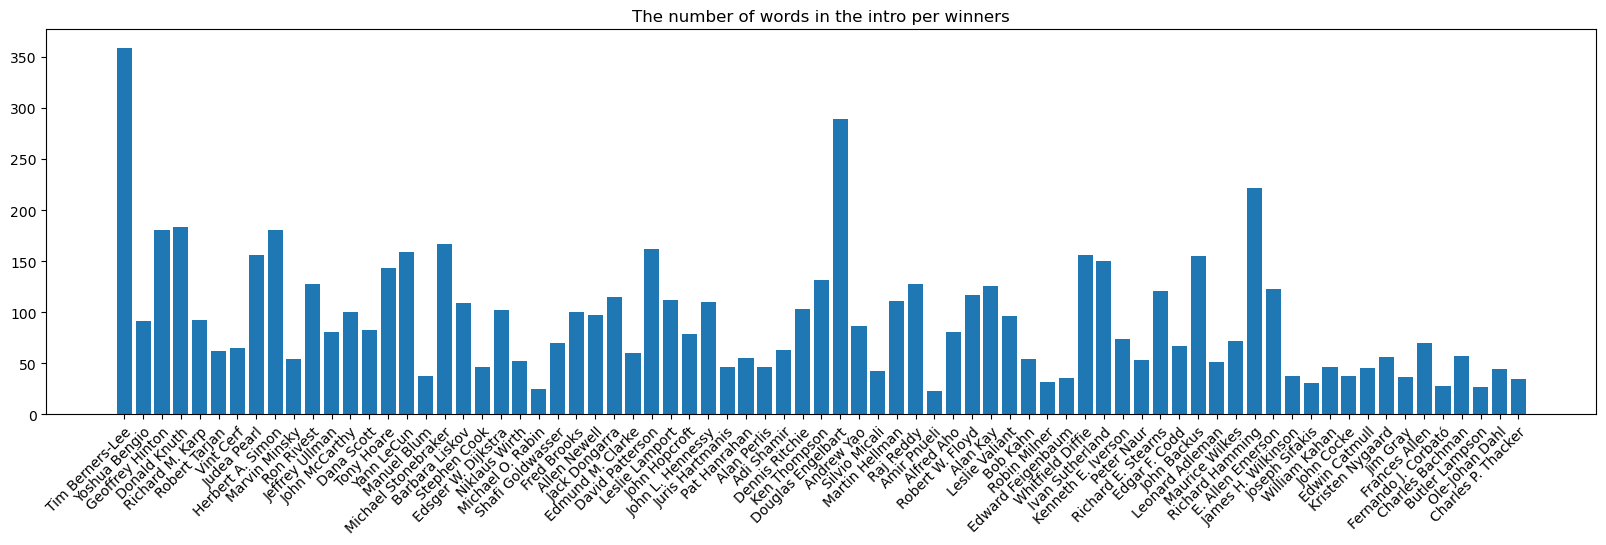

In [1575]:
plt.figure(figsize=(20, 5))
plt.title("The number of words in the intro per winners")
plt.bar(award_winners_intro["winner_name"], award_winners_intro["count_words"])
plt.xticks(rotation = 45, ha = "right", rotation_mode='anchor')
plt.show()

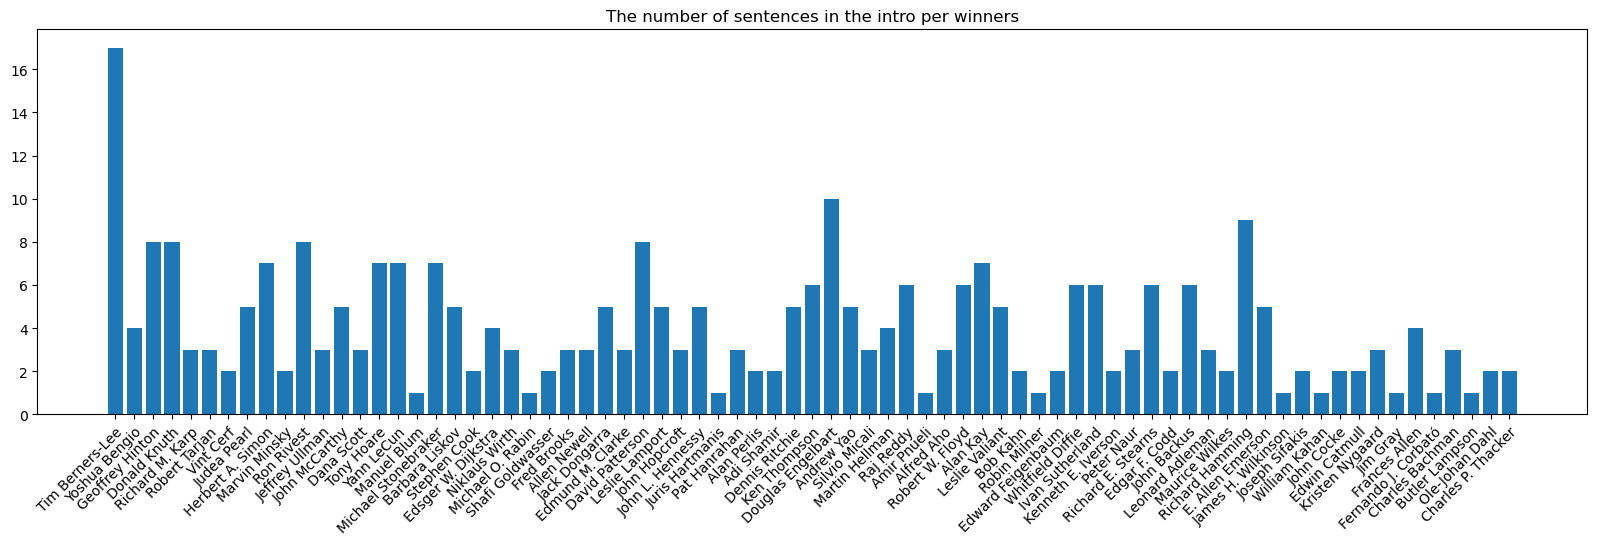

In [1560]:
plt.figure(figsize=(20, 5))
plt.title("The number of sentences in the intro per winners")
plt.bar(award_winners_intro["winner_name"], award_winners_intro["count_sentences"])
plt.xticks(rotation = 45, ha = "right", rotation_mode='anchor')
plt.show()

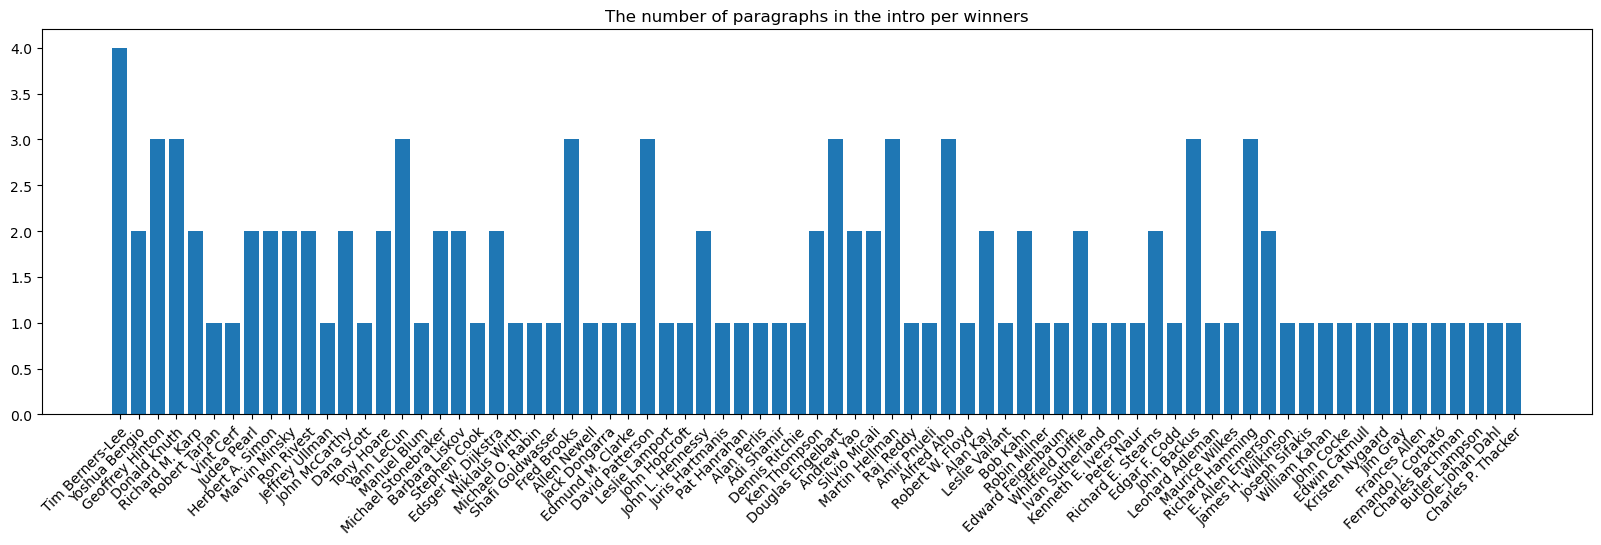

In [1559]:
plt.figure(figsize=(20, 5))
plt.title("The number of paragraphs in the intro per winners")
plt.bar(award_winners_intro["winner_name"], award_winners_intro["count_paragraphs"])
plt.xticks(rotation = 45, ha = "right", rotation_mode='anchor')
plt.show()

### Task 12

/var/folders/dn/rwz32gqj5951m0mt9y7smnn80000gn/T/ipykernel_10778/19626202.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(award_winners_intro["winner_name"], rotation = 45, ha = "right", rotation_mode='anchor')
/var/folders/dn/rwz32gqj5951m0mt9y7smnn80000gn/T/ipykernel_10778/19626202.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(award_winners_intro["winner_name"], rotation = 45, ha = "right", rotation_mode='anchor')
/var/folders/dn/rwz32gqj5951m0mt9y7smnn80000gn/T/ipykernel_10778/19626202.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(award_winners_intro["winner_name"], rotation = 45, ha = "right", rotation_mode='anchor')


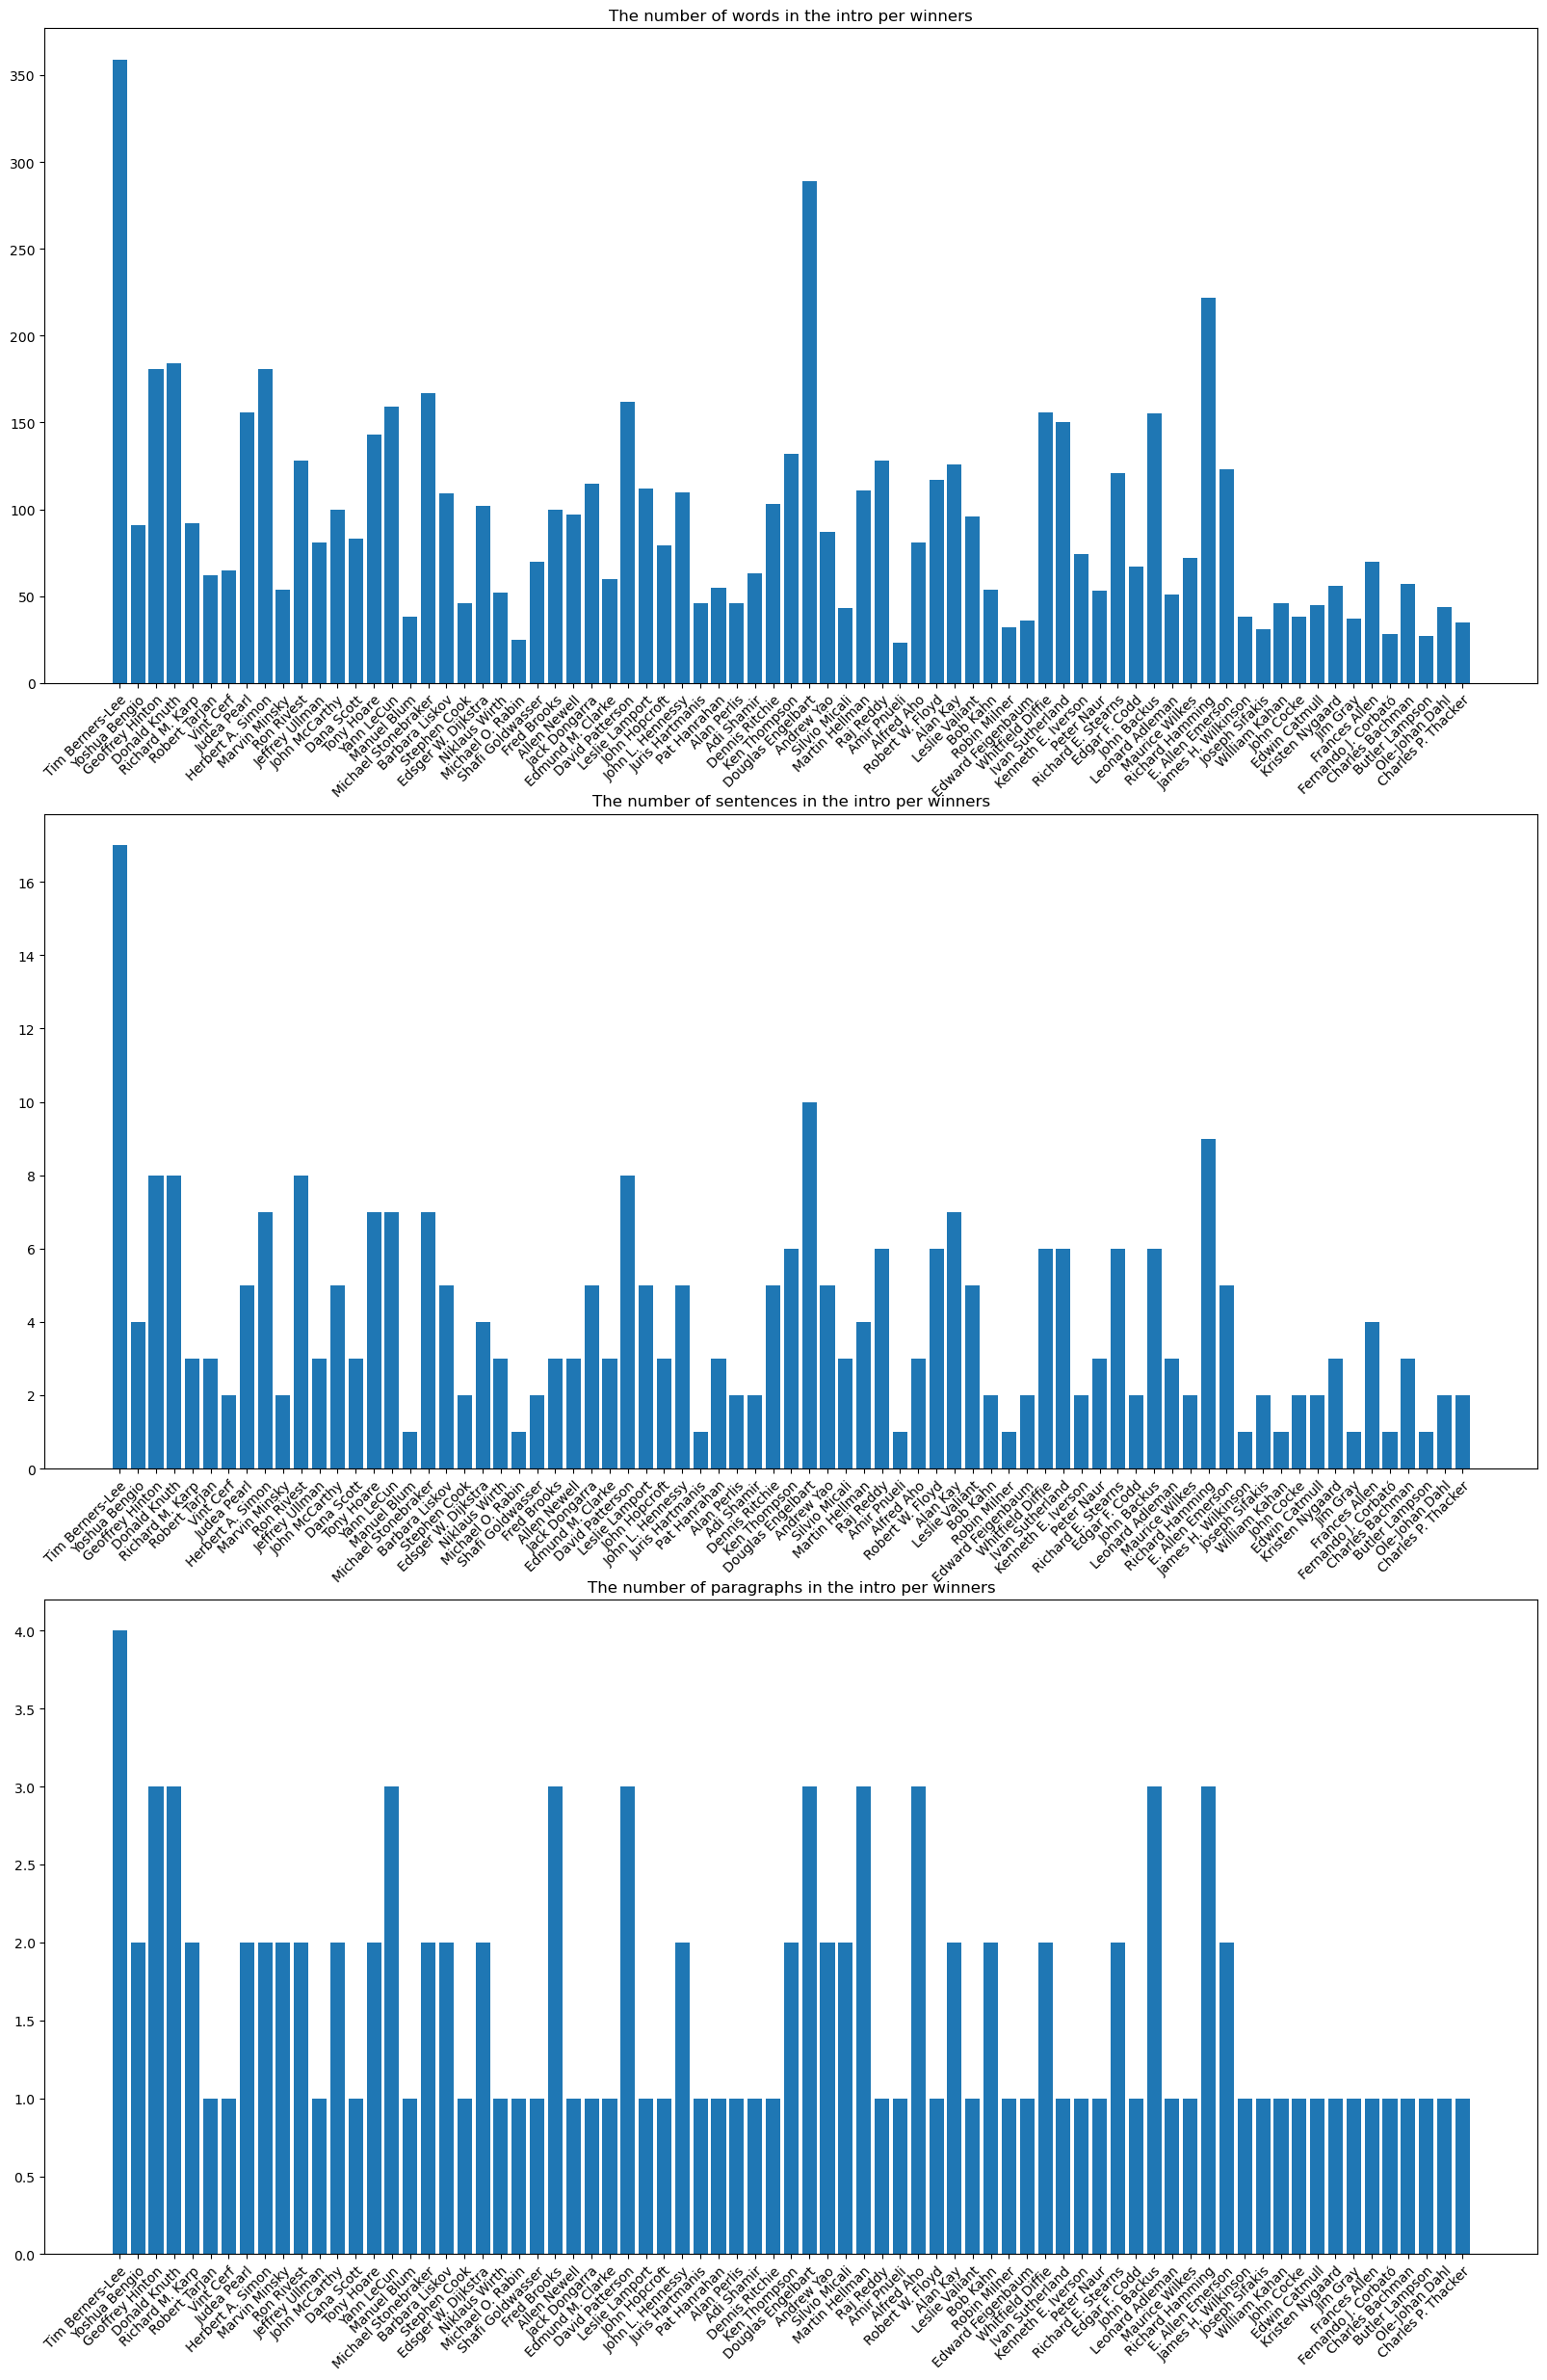

In [1589]:
fig, axs = plt.subplots(3,1, figsize = (20, 30))
axs[0].set_title("The number of words in the intro per winners")
axs[0].bar(award_winners_intro["winner_name"], award_winners_intro["count_words"])
axs[0].set_xticklabels(award_winners_intro["winner_name"], rotation = 45, ha = "right", rotation_mode='anchor')
axs[1].set_title("The number of sentences in the intro per winners")
axs[1].bar(award_winners_intro["winner_name"], award_winners_intro["count_sentences"])
axs[1].set_xticklabels(award_winners_intro["winner_name"], rotation = 45, ha = "right", rotation_mode='anchor')
axs[2].set_title("The number of paragraphs in the intro per winners")
axs[2].bar(award_winners_intro["winner_name"], award_winners_intro["count_paragraphs"])
axs[2].set_xticklabels(award_winners_intro["winner_name"], rotation = 45, ha = "right", rotation_mode='anchor')
plt.show()

### Task 13

/var/folders/dn/rwz32gqj5951m0mt9y7smnn80000gn/T/ipykernel_10778/2277048204.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(sorted_word_count["winner_name"], rotation = 90)


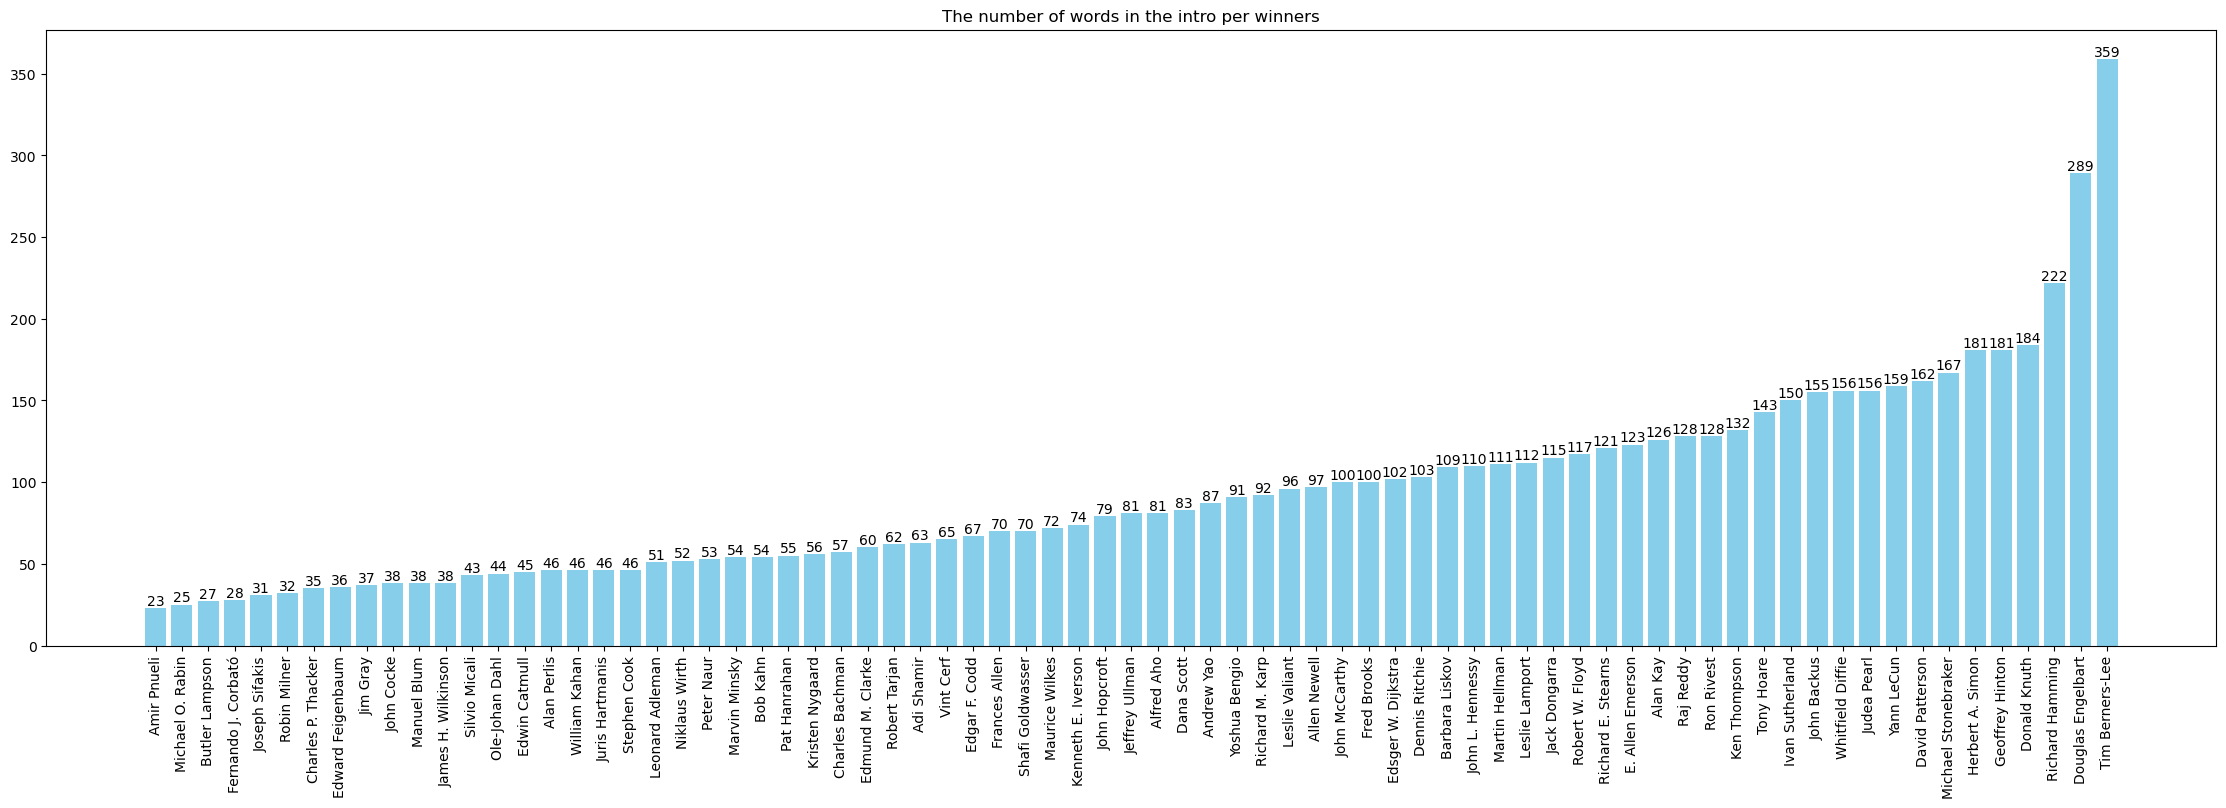

In [1629]:
# 1st barplot
sorted_word_count = award_winners_intro.sort_values(by = "count_words", ascending = True)
fig, ax = plt.subplots()
bars = ax.bar(sorted_word_count["winner_name"], sorted_word_count["count_words"], color = "skyblue")
ax.bar_label(bars)
ax.set_title("The number of words in the intro per winners")
ax.set_xticklabels(sorted_word_count["winner_name"], rotation = 90)
fig.set_size_inches(28, 8)
plt.show()

/var/folders/dn/rwz32gqj5951m0mt9y7smnn80000gn/T/ipykernel_10778/1124058375.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(sorted_sentence_count["winner_name"], rotation = 90)


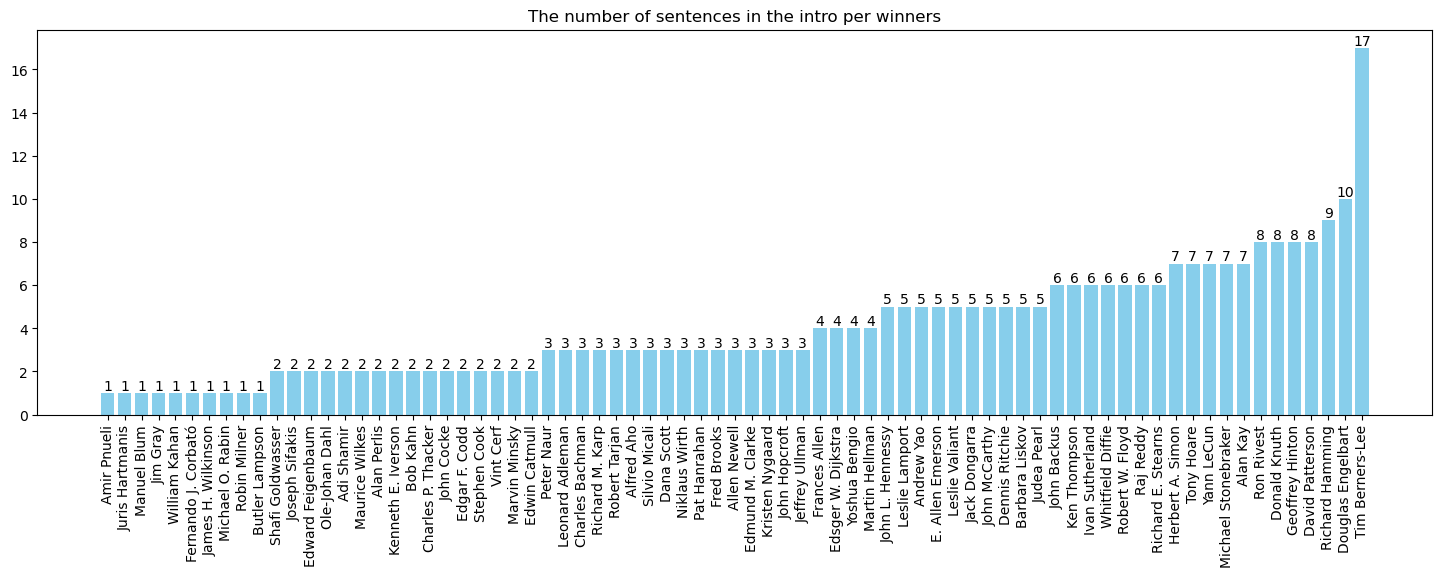

In [1620]:
# 2nd barplot
sorted_sentence_count = award_winners_intro.sort_values(by = "count_sentences", ascending = True)
fig, ax = plt.subplots()
bars = ax.bar(sorted_sentence_count["winner_name"], sorted_sentence_count["count_sentences"], color = "skyblue")
ax.bar_label(bars)
ax.set_title("The number of sentences in the intro per winners")
ax.set_xticklabels(sorted_sentence_count["winner_name"], rotation = 90)
fig.set_size_inches(18, 5)
plt.show()

### 3.3.2 Heatmap

### Task 14